In [22]:
%matplotlib inline

import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import SHConfig, BBox, CRS, DataCollection
from sentinelhub import SentinelHubCatalog

config = SHConfig()
if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub Catalog API, please provide the credentials (client ID and client secret).")

catalog = SentinelHubCatalog(config=config)

In [48]:
from sentinelhub import SentinelHubRequest, filter_times, bbox_to_dimensions, \
    MimeType, SentinelHubDownloadClient

caspian_sea_bbox = BBox([-81, 51.5, -79, 52], crs=CRS.WGS84)
time_interval = '2020-12-10', '2021-01-30'

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L1C,
    bbox=caspian_sea_bbox,
    time=time_interval,
    query={
        "eo:cloud_cover": {
            "lt": 5
        }
    },
    fields={
        "include": [
            "id",
            "properties.datetime",
            "properties.eo:cloud_cover"
        ],
        "exclude": []
    }
)

time_difference = dt.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

unique_acquisitions

[datetime.datetime(2020, 12, 15, 16, 29, 6, tzinfo=tzutc()),
 datetime.datetime(2020, 12, 28, 16, 39, 3, tzinfo=tzutc()),
 datetime.datetime(2021, 1, 17, 16, 38, 55, tzinfo=tzutc()),
 datetime.datetime(2021, 1, 24, 16, 29, 9, tzinfo=tzutc())]

In [49]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(timestamp - time_difference, timestamp + time_difference)
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=caspian_sea_bbox,
        size=bbox_to_dimensions(caspian_sea_bbox, 100),
        config=config
    )
    process_requests.append(request)

(575, 1373, 3)
Wall time: 8.86 s


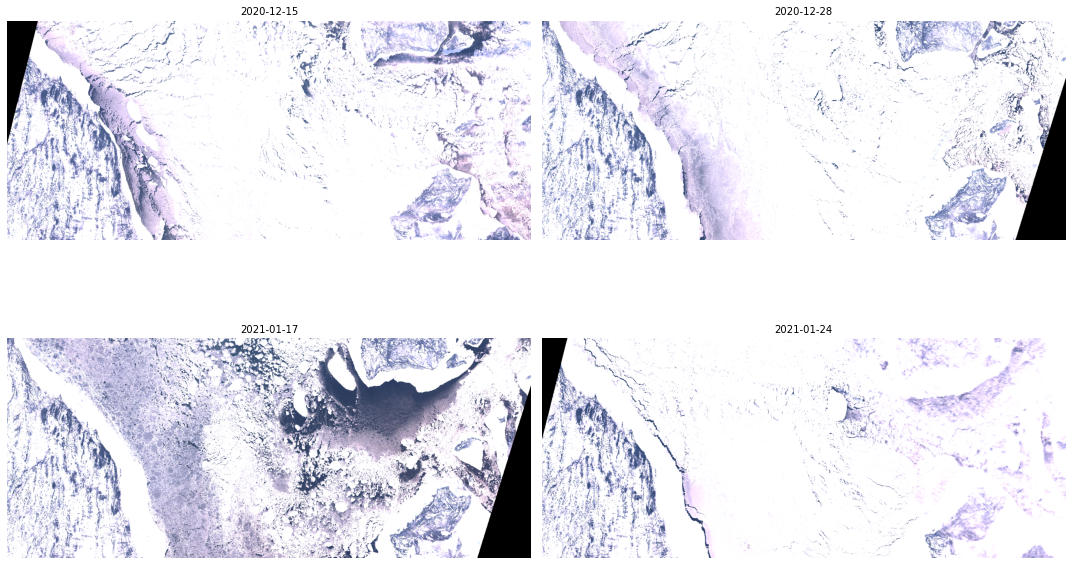

In [50]:
%%time

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

print(data[0].shape)

ncols, nrows = 2, 2

fig, axis = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 10),
    subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
)

for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):
    ax = axis[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(timestamp.date().isoformat(), fontsize=10)

plt.tight_layout()

In [1]:
from sentinelhub import SHConfig

config = SHConfig()

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub Process API, please provide the credentials (client ID and client secret).")

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

# from utils import plot_image

In [4]:
betsiboka_coords_wgs84 = [-75.15884399414064, 63.54356217441293, -72.52212524414064, 64.69910544204765]

In [5]:
resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels')

Image shape at 60 m resolution: (2101, 2184) pixels


In [6]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2020-05-22', '2020-05-28'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

In [7]:
true_color_imgs = request_true_color.get_data()

In [8]:
print(f'Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.')
print(f'Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}')

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2184, 2101, 3)


In [9]:
"""
Utilities used by example notebooks
"""
import matplotlib.pyplot as plt
import numpy as np


def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

Image type: uint8


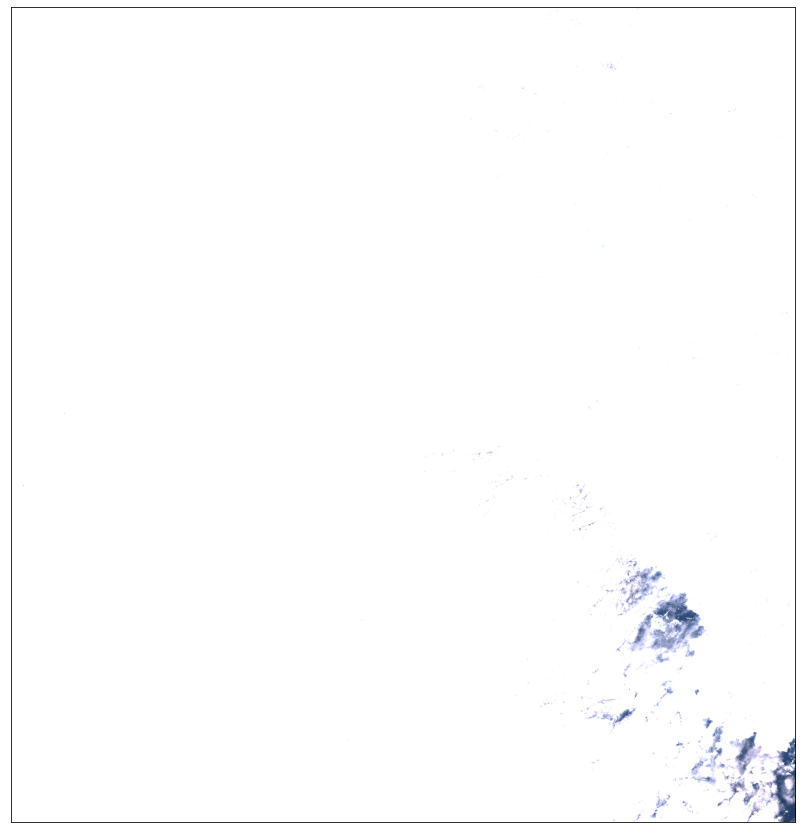

In [10]:
image = true_color_imgs[0]
print(f'Image type: {image.dtype}')

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5/255, clip_range=(0,1))

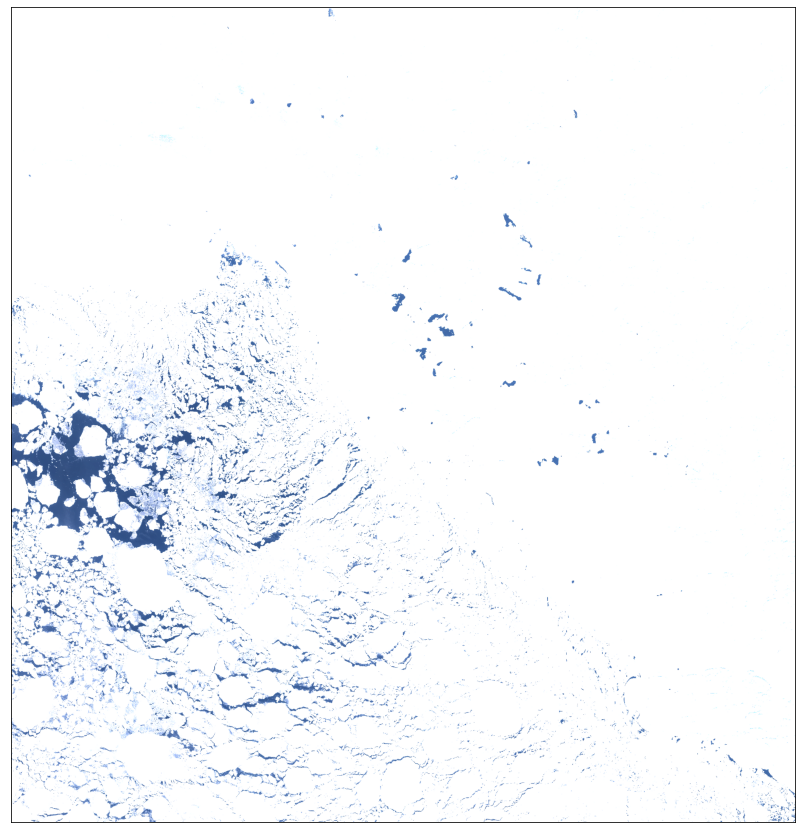

In [11]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2020-03-22', '2020-03-28'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)
plot_image(request_true_color.get_data()[0], factor=3.5/255, clip_range=(0,1))